### why wasserstein
- https://jamesmccaffrey.wordpress.com/2021/08/23/comparing-wasserstein-distance-with-kullback-leibler-distance/

*We haver common support of all points, so in theory KL and JS can be used.

### this impl.
- https://github.com/pkomiske/Wasserstein/
- https://github.com/pkomiske/Wasserstein/blob/master/demos/Wasserstein%20Demo.ipynb
- https://pypi.org/project/Wasserstein/
- https://pkomiske.github.io/Wasserstein/


### Potentiall More scalable version:
- https://github.com/lrcfmd/ElM2D
- https://github.com/sparks-baird/chem_wasserstein
- https://pypi.org/project/chem_wasserstein/
- https://github.com/KrishnaswamyLab/DiffusionEMD

### pytorch appprox:
- https://dfdazac.github.io/sinkhorn.html (THIS!)
- https://github.com/dfdazac/wassdistance
- https://github.com/gpeyre/SinkhornAutoDiff
- https://www.kernel-operations.io/geomloss/index.html
- https://www.kernel-operations.io/geomloss/api/pytorch-api.html (potentially interesting loss!!!)
- https://github.com/dfdazac/wassdistance/blob/master/layers.py (mini batch implimentation)

more pytorch sinkhorn:
- https://gist.github.com/wohlert/8589045ab544082560cc5f8915cc90bd
- https://gist.github.com/noskill/c32f2e6148e14f2f9a2945b03bab42ac

# TODO

- Check scalability on computerome...
- Read more..

In [1]:
import numpy as np
from scipy import stats
import torch
from layers import SinkhornDistance
import wasserstein
import matplotlib.pyplot as plt

import geomloss


# 1d

In [186]:
# data
M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
coords0, coords1 = np.random.rand(2, M,1) # would be spatial coordinates of dist0 and dist1
weights0, weights1 = np.ones([2,M]) # no/same weights

# scipy---------------------------------------------------
wass = stats.wasserstein_distance(coords0.flatten(),coords1.flatten())
print('Wasserstein distance (scipy):', wass)

#wasserstein ---------------------------------------------
emd = wasserstein.EMD(norm=True, n_iter_max = 1000)
emd_val = emd(weights0, coords0, weights1, coords1)
print('Wasserstein distance (wasserstein):', emd_val)

#sinkhorn -------------------------------------------------
x = torch.tensor(coords0, dtype=torch.float)
y = torch.tensor(coords1, dtype=torch.float)
sinkhorn = SinkhornDistance(eps=0.001, max_iter=1000, reduction='none')
dist, P, C = sinkhorn(x, y)
print(f"Sinkhorn distance: {dist.item()}")

# GeomLoss
loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001)
sinkhornLoss = loss(x,y)
print(f"Sinkhorn distance (GeomLoss): {sinkhornLoss}")

Wasserstein distance (scipy): 0.17765372554630218
Wasserstein distance (wasserstein): 0.17765372554630215
Sinkhorn distance: 0.002339408965781331
Sinkhorn distance (GeomLoss): 0.11152660101652145


In [189]:
iterations = 1000

w_list1= []
w_list2= []
s_list1= []
s_list2= []

for i in range(iterations):

    # data
    M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
    coords0, coords1 = np.random.rand(2, M,1) # would be spatial coordinates of dist0 and dist1
    weights0, weights1 = np.ones([2,M]) # no/same weights

    # scipy---------------------------------------------------
    wass = stats.wasserstein_distance(coords0.flatten(),coords1.flatten())
    #print('Wasserstein distance (scipy):', wass)
    w_list1.append(wass)

    #wasserstein ---------------------------------------------
    emd = wasserstein.EMD(norm=True, n_iter_max = 1000)
    emd_val = emd(weights0, coords0, weights1, coords1)
    #print('Wasserstein distance (wasserstein):', emd_val)
    w_list2.append(emd_val)

    #sinkhorn -------------------------------------------------
    x = torch.tensor(coords0, dtype=torch.float)
    y = torch.tensor(coords1, dtype=torch.float)
    sinkhorn = SinkhornDistance(eps=0.001, max_iter=1000, reduction='none')
    dist, P, C = sinkhorn(x, y)
    #print(f"Sinkhorn distance: {dist.item()}")
    s_list1.append(dist)

    # GeomLoss
    loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001)
    sinkhornLoss = loss(x,y)
    #print(f"Sinkhorn distance (GeomLoss): {sinkhornLoss}")
    s_list2.append(sinkhornLoss)

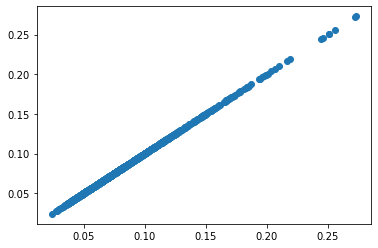

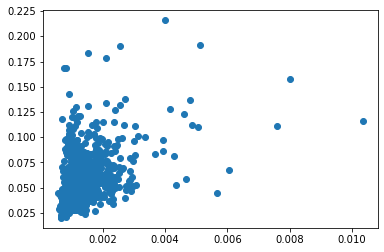

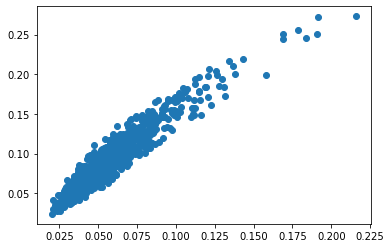

In [192]:
plt.plot(w_list1, w_list2, 'o')
plt.show()
plt.plot(s_list1, s_list2, 'o')
plt.show()
plt.plot(s_list2, w_list2, 'o')
plt.show()

# 2d

In [2]:
def show_wasserstein2d(emdm, weights0, coords0, weights1, coords1):

    flows = emd.flows()

    # plot the events
    plt.scatter(coords0[:,0], coords0[:,1], lw=0, color='red')
    plt.scatter(coords1[:,0], coords1[:,1], lw=0, color='blue')

    # plot flows
    cmap = plt.get_cmap('Greys')
    fmax = flows.max()
    for i in range(len(weights0)):
        for j in range(len(weights1)):
            f = flows[i,j]
            if f > 0.:
                plt.plot([coords0[i,0], coords1[j,0]], [coords0[i,1], coords1[j,1]],
                        lw=1.5, color=cmap(f/fmax), zorder=0)

    plt.axis('off')
    plt.show()



def show_sinkhorn2d(a, b, P):    
    norm_P = P/P.max()
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            plt.arrow(a[i, 0], a[i, 1], b[j, 0]-a[i, 0], b[j, 1]-a[i, 1],
                     alpha=norm_P[i,j].item())
    plt.scatter(a[:, 0], a[:, 1], color='red')
    plt.scatter(b[:, 0], b[:, 1], color='blue')
    plt.axis('off')

In [54]:
# data
M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
coords0, coords1 = np.random.rand(2, M, 2) # would be spatial coordinates of dist0 and dist1
weights0, weights1 = np.ones([2,M]) # no/same weights

#wasserstein ---------------------------------------------
emd = wasserstein.EMD(norm=True, n_iter_max = 1000)
emd_val = emd(weights0, coords0, weights1, coords1)
print('Wasserstein distance:', emd_val)


#sinkhorn -------------------------------------------------
x = torch.tensor(coords0, dtype=torch.float)
y = torch.tensor(coords1, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.0001, max_iter=1000, reduction='none')
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

Wasserstein distance: 0.15374984417778084
Sinkhorn distance: 0.014


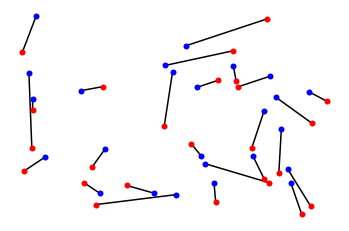

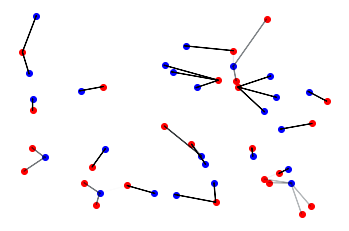

In [56]:
show_wasserstein2d(emd, weights0, coords0, weights1, coords1)
show_sinkhorn2d(x, y, P)

# corr between wasserstein and sinkhorn (2d)

In [61]:
w_list = []
s_list = []

iterations = 1000

for i in range(iterations):

    # data
    M = 100
    coords0, coords1 = np.random.rand(2, M, 2) 
    weights0, weights1 = np.ones([2,M])

    #wasserstein ---------------------------------------------
    emd = wasserstein.EMD(norm = True, n_iter_max = 10000)
    emd_val = emd(weights0, coords0, weights1, coords1)
    w_list.append(emd_val)


    #sinkhorn -------------------------------------------------
    x = torch.tensor(coords0, dtype=torch.float)
    y = torch.tensor(coords1, dtype=torch.float)

    sinkhorn = SinkhornDistance(eps=0.0001, max_iter=10000, reduction='none')
    dist, P, C = sinkhorn(x, y)
    s_list.append(dist.item())

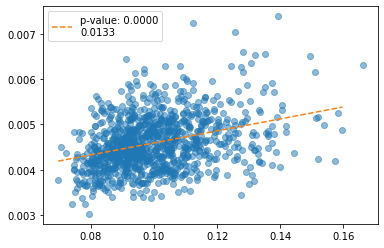

In [62]:
results=stats.linregress(w_list, s_list)

reg_x = np.arange(min(w_list), max(w_list), 0.01)
reg_y = results.intercept + results.slope*reg_x

plt.plot(w_list, s_list, 'o', alpha = 0.5)
plt.plot(reg_x, reg_y, '--', label = f'p-value: {results.pvalue:.4f}\n{results.slope:.4f}')
plt.legend()
plt.show()

# 3D

### Wasserstein
- https://github.com/pkomiske/Wasserstein/
- https://github.com/pkomiske/Wasserstein/blob/master/demos/Wasserstein%20Demo.ipynb


### Sinkhorn
- https://dfdazac.github.io/sinkhorn.html
- https://github.com/dfdazac/wassdistance

In [63]:
def show_wasserstein3d(emdm, weights0, coords0, weights1, coords1):

    flows = emd.flows()

    # plot the events
    zf = 100
    plt.scatter(coords0[:,0], coords0[:,1], s=zf*weights0, lw=0, color='red')
    plt.scatter(coords1[:,0], coords1[:,1], s=zf*weights1, lw=0, color='blue')

    # plot flows
    cmap = plt.get_cmap('Greys')
    fmax = flows.max()
    for i in range(len(weights0)):
        for j in range(len(weights1)):
            f = flows[i,j]
            if f > 0.:
                plt.plot([coords0[i,0], coords1[j,0]], [coords0[i,1], coords1[j,1]],
                        lw=1.5, color=cmap(f/fmax), zorder=0)

    plt.axis('off')
    plt.show()


def show_sinkhorn3d(a, b, P):    
    norm_P = P/P.max()
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            plt.arrow(a[i, 0], a[i, 1], b[j, 0]-a[i, 0], b[j, 1]-a[i, 1],
                     alpha=norm_P[i,j].item())
    plt.scatter(a[:, 0], a[:, 1], s=a[:,2]*100, color='red')
    plt.scatter(b[:, 0], b[:, 1], s=b[:,2]*100, color='blue')
    plt.axis('off')

In [67]:
#data

# get some points in a euclidean space - but now also with magnitude/weights
M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
coords0, coords1 = np.random.rand(2, M, 2) # would be spatial coordinates of dist0 and dist1
weights0, weights1 = np.random.rand(2, M) # would be the true/estimated values for each point.


#Wasserstein ----------------------------
emd = wasserstein.EMD(norm = True, n_iter_max = 10000)
emd_val = emd(weights0, coords0, weights1, coords1)
print('Wasserstein distance:', emd_val)


# Sinkhorn -------------------------------
a = np.column_stack([coords0, weights0])
b = np.column_stack([coords1, weights1])

x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.01, max_iter=10000, reduction=None)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

Wasserstein distance: 0.15742042220028216
Sinkhorn distance: 0.073


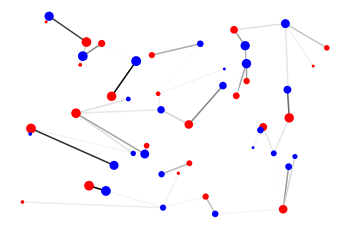

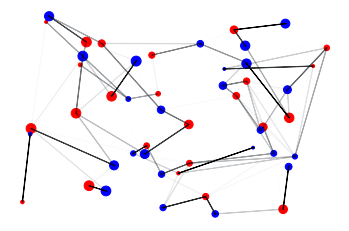

In [68]:
show_wasserstein3d(emd, weights0, coords0, weights1, coords1)
show_sinkhorn3d(a, b, P)

# corr between wasserstein and sinkhorn (3d)

In [10]:
w_list = []
s_list = []

iterations = 1000

for i in range(iterations):

    M = 100
    coords0, coords1 = np.random.rand(2, M, 2) 
    weights0, weights1 = np.random.rand(2, M) 


    #Wasserstein ----------------------------
    emd = wasserstein.EMD(n_iter_max = 10000)
    emd_val = emd(weights0, coords0, weights1, coords1)
    w_list.append(emd_val)

    # Sinkhorn -------------------------------
    a = np.column_stack([coords0, weights0])
    b = np.column_stack([coords1, weights1])

    x = torch.tensor(a, dtype=torch.float)
    y = torch.tensor(b, dtype=torch.float)

    sinkhorn = SinkhornDistance(eps=0.0001, max_iter=10000, reduction=None)
    dist, P, C = sinkhorn(x, y)
    s_list.append(dist.item())

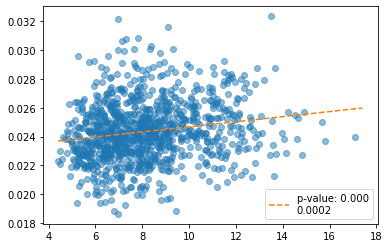

In [11]:
results=stats.linregress(w_list, s_list)

reg_x = np.arange(min(w_list), max(w_list)+1, 1)
reg_y = results.intercept + results.slope*reg_x

plt.plot(w_list, s_list, 'o', alpha = 0.5)
plt.plot(reg_x, reg_y, '--', label = f'p-value: {results.pvalue:.3f}\n{results.slope:.4f}')
plt.legend()
plt.show()

# sinkhorn (GeomLoss)
- https://www.kernel-operations.io/geomloss/index.html

tensor(0.1497)